# Dynamic Flux Balance Analysis Using Models Generated with ModelSEED

This notebook will expand on the original flux balance by examining the metabolic optimization of different cell models with dynamic substrate uptake rates, instead of a fixed substrate uptake rate. This notebook uses the COMETS platform, from module 13, to conduct dFBA. The models were generated through kBase.us, using the ModelSEED application. The goal is to evaluate the efficiency of the ModelSEED pipeline on annotated genomes by comparing the generated models to well curated models from the BiGG database.

## kBase and ModelSEED

First, sign in to kBase.us (https://www.kbase.us) or create a new account. Then under the narratives tab, create a new narrative. In the new narraative, under the apps section, select metabolic modeling and find the ModelSEED app. In the data section, click the "+" sign, select "public", search for the organism of interest, and add it to your data. Finally, add the genome to the input for the ModelSEED app, change the parameters as needed, rename the output, and press run. This will create the model and add it directly to your data where you can download it. The models used in this script used RefGlucoseMinimal as the gapfilling media and this media can be added to the narrative the same way as the genomes.

In [ ]:
%reset

In [1]:
# Imports
import cometspy as cp
import cobra as cb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.colors as clrs
import os

In [2]:
# set Gurobi environment variable to the gurobi install location on your computer
os.environ['gurobi'] = '/Users/samlerner/opt/miniconda3/share/doc/gurobi'

In [256]:
# Load models
ec_ms = cb.io.read_sbml_model('e_coli_modelSEED3.xml')
sa_ms = cb.io.read_sbml_model('s_aureus_modelSEED3.xml')
ec_b = cb.io.read_sbml_model('e_coli_BiGG.xml')
sa_b = cb.io.read_sbml_model('s_aureus_BiGG.xml')

In [257]:
# turn off all exchange reactions (it's always good to start with a blank slate)
for ex in ec_ms.exchanges:
    ex.lower_bound = 0.
    ex.upper_bound = 1000.
for ex in sa_ms.exchanges:
    ex.lower_bound = 0.
    ex.upper_bound = 1000.
for ex in ec_b.exchanges:
    ex.lower_bound = 0.
    ex.upper_bound = 1000.
for ex in sa_b.exchanges:
    ex.lower_bound = 0.
    ex.upper_bound = 1000.

## Defining Medias

The code chunk directly below defines the media for the models from the BiGG database. The code chunk below that, defines the media for the models built using ModelSEED. Because the two types of models were made using different platforms, the reactions are labeled differently. The names of the different metabolites can be found at [BiGG database](http://bigg.ucsd.edu/models/iML1515) or [ModelSEED Database](https://modelseed.org/biochem/compounds). The metabolites that were editted out in the ModelSEED media were not defined in the respective models, so they were removed from the media.

In [246]:
# Define Media
# Define Base Media
# Structure ['exchange ID',concentration(mmols)]
# minimal media (look up BiGG Metabolites to find more info on IDs) (No Carbon Source)
min_med_b = [['EX_h2o_e',1000.],#aerobic base
           ['EX_h_e',1000.],
           ['EX_co2_e',1000.],
           ['EX_fe3_e',1000.],#metals
           ['EX_mn2_e',1000.],
           ['EX_fe2_e',1000.],
           ['EX_zn2_e',1000.],
           ['EX_mg2_e',1000.],
           ['EX_ca2_e',1000.],
           ['EX_ni2_e',1000.],
           ['EX_cobalt2_e',1000.],
           ['EX_mobd_e',1000.],
           ['EX_k_e',1000.],
           ['EX_na1_e',1000.],
           ['EX_cl_e',1000.],
           ['EX_nh4_e',1000.],#nitrogen source
           ['EX_pi_e',1000.],#phosphorus source
           ['EX_so4_e',1000.]]#sulfer source
           

    
# Define Additional Media Components
glucose_b = [['EX_glc__D_e',10]]#carbon source
oxygen_b = [['EX_o2_e',1000.]]

vol = 0.1

In [259]:
# Define Media
# Define Base Media
# Structure ['exchange ID',concentration(mmols)]
# minimal media (look up BiGG Metabolites to find more info on IDs) (No Carbon Source)
min_med_m = [['EX_cpd00001_e',1000.], #H2O
           ['EX_cpd00063_e',1000.], # Ca2+
           ['EX_cpd00009_e',1000.], # Phosphate
           ['EX_cpd00013_e',1000.], # NH3
           ['EX_cpd00034_e',1000.], # Zn2+
           ['EX_cpd00030_e',1000.], # Mn2+
           ['EX_cpd00048_e',1000.], # Sulfate
           ['EX_cpd00058_e',1000.], # Cu2+
           ['EX_cpd00067_e',1000.], # H+
           ['EX_cpd00099_e',1000.], # Cl-
           ['EX_cpd00149_e',1000.], # Co2+
           ['EX_cpd00205_e',1000.], # K+
           #['EX_cpd00244_e',1000.], # Ni2+
           ['EX_cpd00254_e',1000.], # Mg
           ['EX_cpd00971_e',1000.], # Na+
           #['EX_cpd10515_e',1000.], # Fe+2
           ['EX_cpd10516_e',1000.]] # Fe+3
           #['EX_cpd11574_e',1000.]] # Molybdate
           
# Define Additional Media Components
glucose_m = [['EX_cpd00027_e',10]]#carbon source
oxygen_m = [['EX_cpd00007_e',1000.]]

vol = 0.1

## Creating the COMETS models and Running the Simulations

The code chunk below converts the imported COBRA model into a COMETS model. The initial populations of the modeled populations are defined, the exchange reactions are opened, the optimization method is set, and parameters for the simulation are defined. The following four chunks of code run the simulations for the four different models.

In [260]:
# Create COMETS model from COBRA model
ec_b.id = "ec_b_model"
ec_b_model_comets = cp.model(ec_b)
sa_b.id = "sa_b_model"
sa_b_model_comets = cp.model(sa_b)
ec_ms.id = "ec_ms_model"
ec_ms_model_comets = cp.model(ec_ms)
sa_ms.id = "sa_ms_model"
sa_ms_model_comets = cp.model(sa_ms)

# set initial population
initial_pop = 1.e-3 #gDW
ec_b_model_comets.initial_pop = [0,0,initial_pop]
sa_b_model_comets.initial_pop = [0,0,initial_pop]
ec_ms_model_comets.initial_pop = [0,0,initial_pop]
sa_ms_model_comets.initial_pop = [0,0,initial_pop]

# open exchange reactions
ec_b_model_comets.open_exchanges()
sa_b_model_comets.open_exchanges()
ec_ms_model_comets.open_exchanges()
sa_ms_model_comets.open_exchanges()

# Set the optimization method
ec_b_model_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
sa_b_model_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
ec_ms_model_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
sa_ms_model_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

# Set Params
params = cp.params()

# Adjust Params
params.set_param("spaceWidth",vol**(1/3))
params.set_param("defaultVmax",10.)
params.set_param("defaultKm",0.01)

# Set timestep
t_step = 0.1
t_total = 200

params.set_param("timeStep",t_step) #hours
params.set_param("maxSpaceBiomass",10.) #max grams of biomass in a box
params.set_param("maxCycles",t_total)
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)

In [261]:
# Create Layout and Run
# Create the layout
layout_glc = cp.layout([sa_b_model_comets])

# Specify metabolites in layout
# minimal medium + glucose
tmp_medium_b = min_med_b + glucose_b + oxygen_b

for component in tmp_medium_b:
    met = component[0][3:]
    c = component[1]
    mmol = c*vol
    layout_glc.set_specific_metabolite(met,mmol)
    
# Create comets object
sa_b_sim = cp.comets(layout_glc, params)

# Run Simulation
sa_b_sim.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/lib/gurobi.jar

  You have two options to fix this problem:
1.  set each class path correctly by doing:
    comets.set_classpath(libraryname, path)
    e.g.   comets.set_classpath('hamcrest', '/home/chaco001/comets/junit/hamcrest-core-1.3.jar')

    note that versions dont always have to exactly match, but you're on your own if they don't

2.  fully define the classpath yourself by overwriting comets.JAVA_CLASSPATH
       look at the current comets.JAVA_CLASSPATH to see how this should look.

Running COMETS simulation ...


/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a'

Done!


In [262]:
# Create Layout and Run
# Create the layout
layout_glc = cp.layout([ec_b_model_comets])

# Specify metabolites in layout
# minimal medium + glucose
tmp_medium_b = min_med_b + glucose_b + oxygen_b

for component in tmp_medium_b:
    met = component[0][3:]
    c = component[1]
    mmol = c*vol
    layout_glc.set_specific_metabolite(met,mmol)
    
# Create comets object
ec_b_sim = cp.comets(layout_glc, params)

# Run Simulation
ec_b_sim.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/lib/gurobi.jar

  You have two options to fix this problem:
1.  set each class path correctly by doing:
    comets.set_classpath(libraryname, path)
    e.g.   comets.set_classpath('hamcrest', '/home/chaco001/comets/junit/hamcrest-core-1.3.jar')

    note that versions dont always have to exactly match, but you're on your own if they don't

2.  fully define the classpath yourself by overwriting comets.JAVA_CLASSPATH
       look at the current comets.JAVA_CLASSPATH to see how this should look.

Running COMETS simulation ...


/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a'

Done!


In [263]:
# Create Layout and Run
# Create the layout
layout_glc = cp.layout([sa_ms_model_comets])

# Specify metabolites in layout
# minimal medium + glucose
tmp_medium_m = min_med_m + glucose_m + oxygen_m

for component in tmp_medium_m:
    met = component[0][3:]
    c = component[1]
    mmol = c*vol
    layout_glc.set_specific_metabolite(met,mmol)
    
# Create comets object
sa_ms_sim = cp.comets(layout_glc, params)

# Run Simulation
sa_ms_sim.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/lib/gurobi.jar

  You have two options to fix this problem:
1.  set each class path correctly by doing:
    comets.set_classpath(libraryname, path)
    e.g.   comets.set_classpath('hamcrest', '/home/chaco001/comets/junit/hamcrest-core-1.3.jar')

    note that versions dont always have to exactly match, but you're on your own if they don't

2.  fully define the classpath yourself by overwriting comets.JAVA_CLASSPATH
       look at the current comets.JAVA_CLASSPATH to see how this should look.

Running COMETS simulation ...


/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a'

Done!


In [264]:
# Create Layout and Run
# Create the layout
layout_glc = cp.layout([ec_ms_model_comets])

# Specify metabolites in layout
# minimal medium + glucose
tmp_medium_m = min_med_m + glucose_m + oxygen_m

for component in tmp_medium_m:
    met = component[0][3:]
    c = component[1]
    mmol = c*vol
    layout_glc.set_specific_metabolite(met,mmol)
    
# Create comets object
ec_ms_sim = cp.comets(layout_glc, params)

# Run Simulation
ec_ms_sim.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/lib/gurobi.jar

  You have two options to fix this problem:
1.  set each class path correctly by doing:
    comets.set_classpath(libraryname, path)
    e.g.   comets.set_classpath('hamcrest', '/home/chaco001/comets/junit/hamcrest-core-1.3.jar')

    note that versions dont always have to exactly match, but you're on your own if they don't

2.  fully define the classpath yourself by overwriting comets.JAVA_CLASSPATH
       look at the current comets.JAVA_CLASSPATH to see how this should look.

Running COMETS simulation ...


/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a'

Done!


## Comparing the Simulation Results of BiGG models and ModelSEED Generated Models

The plots below compare the simulation results of the different types of models. The first two generated plots represent the biomasses of the modeled populations, comparing the BiGG models to the ModelSEED models for both Staphylococcus aureus and escherichia coli. The two plots after show the metabolite concentrations over time of the two e. coli models. The last two plots display the intracellular flux of ATP synthase, comparing the two different e. coli models.

Text(0.5, 1.0, 'S. aureus')

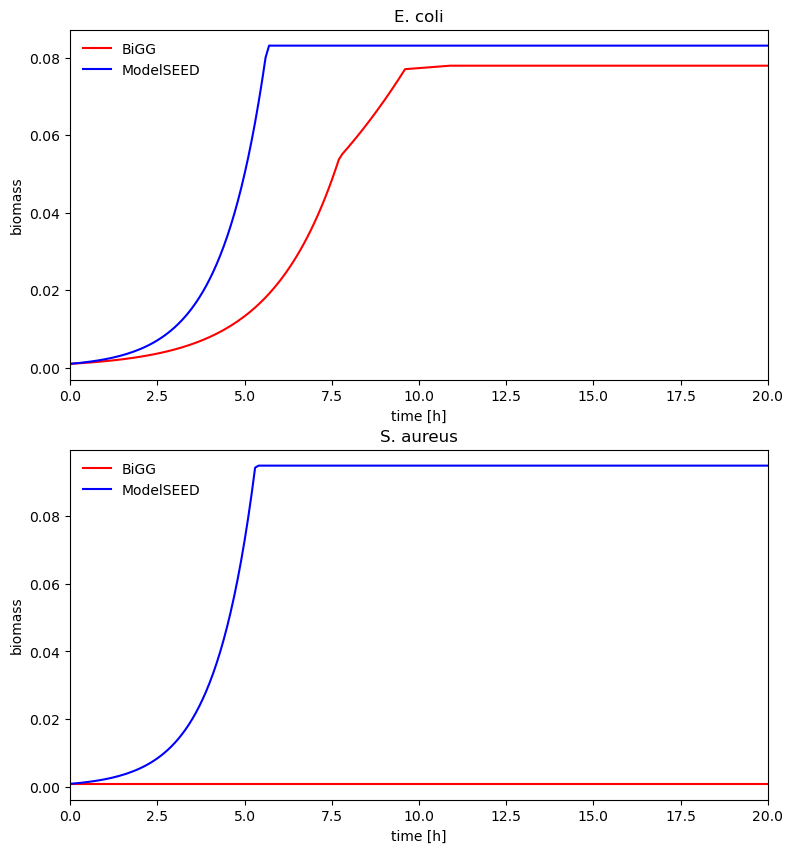

In [274]:
# Plotting
[fig,axs]=plt.subplots(2,1,figsize=[9,10])
t_array = np.arange(0,(t_total+t_step/2)*t_step,t_step)

# Plot Biomass
ec_b_biomass_glc = np.array(ec_b_sim.total_biomass.ec_b_model)
ec_ms_biomass_glc = np.array(ec_ms_sim.total_biomass.ec_ms_model)
axs[0].plot(t_array,ec_b_biomass_glc,'r-', label = 'BiGG')
axs[0].plot(t_array,ec_ms_biomass_glc,'b-', label = 'ModelSEED')
axs[0].legend(frameon=False, loc='upper left', ncol=1)
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('biomass');
axs[0].set_xlim(0,20)
axs[0].set_title("E. coli")

sa_b_biomass_glc = np.array(sa_b_sim.total_biomass.sa_b_model)
sa_ms_biomass_glc = np.array(sa_ms_sim.total_biomass.sa_ms_model)
axs[1].plot(t_array,sa_b_biomass_glc,'r-', label = 'BiGG')
axs[1].plot(t_array,sa_ms_biomass_glc,'b-', label = 'ModelSEED')
axs[1].legend(frameon=False, loc='upper left', ncol=1)
axs[1].set_xlabel('time [h]')
axs[1].set_ylabel('biomass');
axs[1].set_xlim(0,20)
axs[1].set_title("S. aureus")


Text(0.5, 1.0, 'E. coli ModelSEED Model')

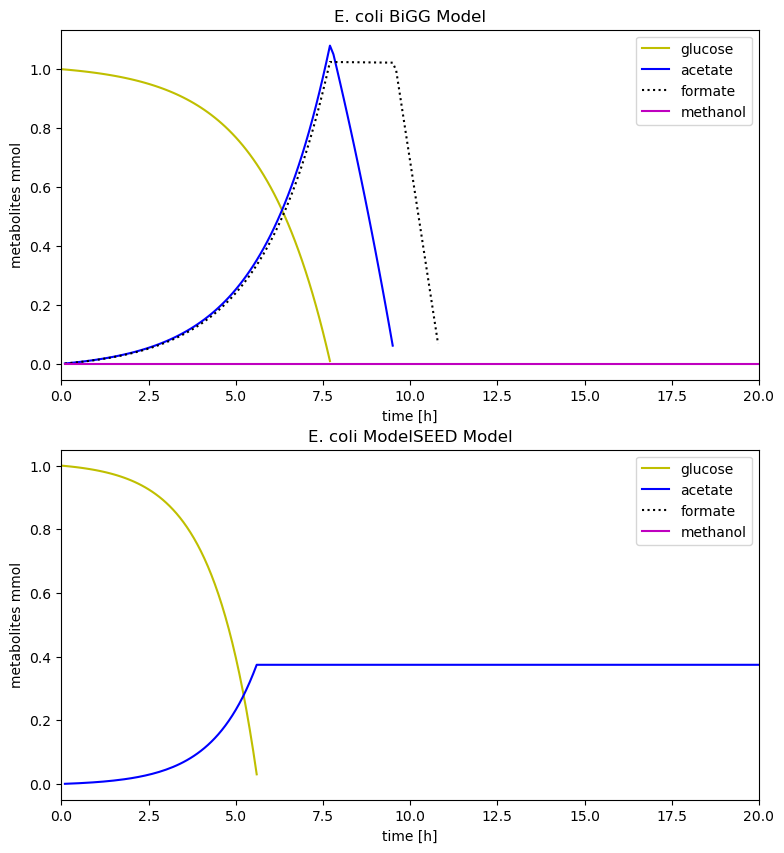

In [297]:
# Plot metabolites
[fig,axs]=plt.subplots(2,1,figsize=[9,10])

ec_b_md = ec_b_sim.media
axs[0].plot(t_array[ec_b_md.loc[ec_b_md['metabolite']=='glc__D_e'].cycle.values],ec_b_md.loc[ec_b_md['metabolite']=='glc__D_e'].conc_mmol.values,'y')#glucose
axs[0].plot(t_array[ec_b_md.loc[ec_b_md['metabolite']=='ac_e'].cycle.values],ec_b_md.loc[ec_b_md['metabolite']=='ac_e'].conc_mmol.values,'b') #acetate
axs[0].plot(t_array[ec_b_md.loc[ec_b_md['metabolite']=='for_e'].cycle.values],ec_b_md.loc[ec_b_md['metabolite']=='for_e'].conc_mmol.values,'k:') #formate
axs[0].plot(t_array[ec_b_md.loc[ec_b_md['metabolite']=='meoh_e'].cycle.values],ec_b_md.loc[ec_b_md['metabolite']=='meoh_e'].conc_mmol.values,'m') #methanol

axs[0].set_ylabel('metabolites mmol')
axs[0].set_xlabel('time [h]')
axs[0].set_xlim(0,20)
axs[0].legend(['glucose','acetate','formate','methanol'])
axs[0].set_title("E. coli BiGG Model")

ec_ms_md = ec_ms_sim.media
axs[1].plot(t_array[ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00027_e'].cycle.values],ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00027_e'].conc_mmol.values,'y')#glucose
axs[1].plot(t_array[ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00029_e'].cycle.values],ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00029_e'].conc_mmol.values,'b') #acetate
axs[1].plot(t_array[ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00047_e'].cycle.values],ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00047_e'].conc_mmol.values,'k:') #formate
axs[1].plot(t_array[ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00116_e'].cycle.values],ec_ms_md.loc[ec_ms_md['metabolite']=='cpd00116_e'].conc_mmol.values,'m') #methanol

axs[1].set_ylabel('metabolites mmol')
axs[1].set_xlabel('time [h]')
axs[1].set_xlim(0,20)
axs[1].legend(['glucose','acetate','formate','methanol'])
axs[1].set_title("E. coli ModelSEED Model")

Text(0.5, 1.0, 'E. coli ModelSEED Model')

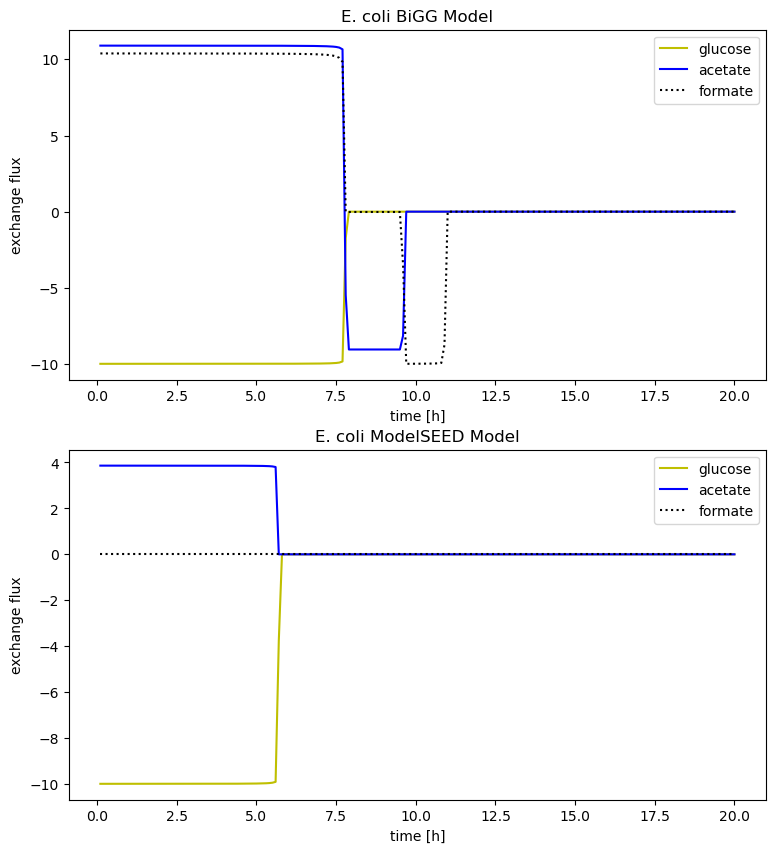

In [299]:
# Plot Exchange Fluxes
[fig,axs]=plt.subplots(2,1,figsize=[9,10])

r = 'EX_glc__D_e' 
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_b_sim.get_flux_image(model_id = 'ec_b_model', reaction_id = r, cycle = i+1)[0][0]
axs[0].plot(t_array[1:],flx_r,'y')
r = 'EX_ac_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_b_sim.get_flux_image(model_id = 'ec_b_model', reaction_id = r, cycle = i+1)[0][0]
axs[0].plot(t_array[1:],flx_r,'b')
r = 'EX_for_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_b_sim.get_flux_image(model_id = 'ec_b_model', reaction_id = r, cycle = i+1)[0][0]
axs[0].plot(t_array[1:],flx_r,'k:')

axs[0].legend(['glucose','acetate','formate'])
axs[0].set_ylabel('exchange flux')
axs[0].set_xlabel('time [h]')
axs[0].set_title("E. coli BiGG Model")
    
    

r = 'EX_cpd00027_e' 
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_ms_sim.get_flux_image(model_id = 'ec_ms_model', reaction_id = r, cycle = i+1)[0][0]
axs[1].plot(t_array[1:],flx_r,'y')
r = 'EX_cpd00029_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_ms_sim.get_flux_image(model_id = 'ec_ms_model', reaction_id = r, cycle = i+1)[0][0]
axs[1].plot(t_array[1:],flx_r,'b')
r = 'EX_cpd00047_e'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_ms_sim.get_flux_image(model_id = 'ec_ms_model', reaction_id = r, cycle = i+1)[0][0]
axs[1].plot(t_array[1:],flx_r,'k:')

axs[1].legend(['glucose','acetate','formate'])
axs[1].set_ylabel('exchange flux')
axs[1].set_xlabel('time [h]')
axs[1].set_title("E. coli ModelSEED Model")

Text(0.5, 1.0, 'E. coli ModelSEED Model')

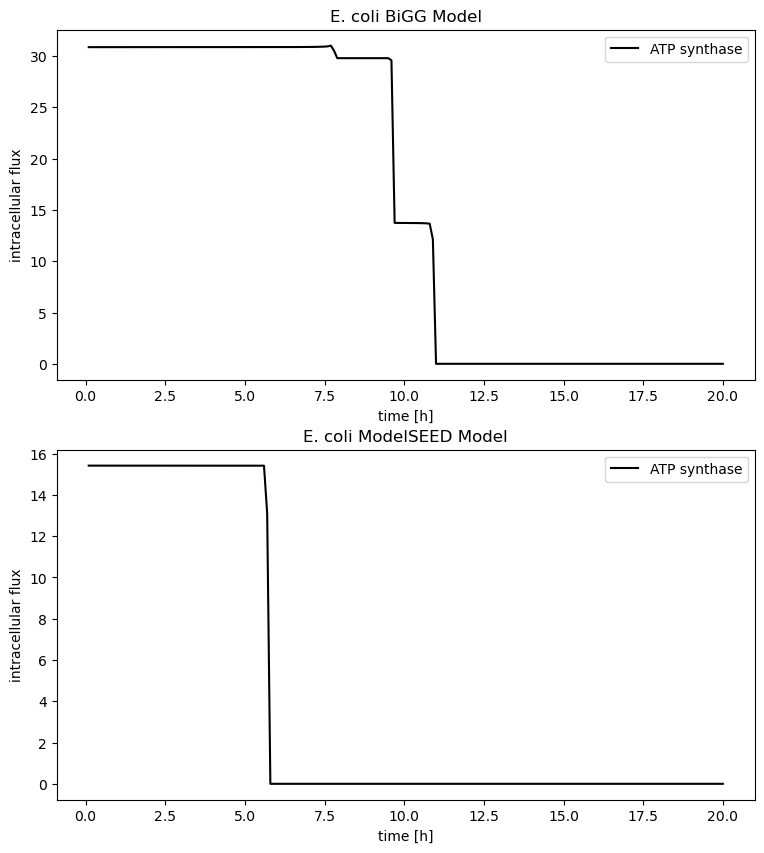

In [325]:
#intracellular fluxes
[fig,axs]=plt.subplots(2,1,figsize=[9,10])

r = 'ATPS4rpp'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_b_sim.get_flux_image(model_id = 'ec_b_model', reaction_id = r, cycle = i+1)[0][0]
axs[0].plot(t_array[1:],flx_r,'k')

axs[0].set_ylabel('intracellular flux')
axs[0].set_xlabel('time [h]')
axs[0].legend(['ATP synthase'])
axs[0].set_title("E. coli BiGG Model")
    
    
r = 'rxn08173_c0'
flx_r = np.zeros(200)
for i in range(200):
    flx_r[i] = ec_ms_sim.get_flux_image(model_id = 'ec_ms_model', reaction_id = r, cycle = i+1)[0][0]
axs[1].plot(t_array[1:],flx_r,'k')

axs[1].set_ylabel('intracellular flux')
axs[1].set_xlabel('time [h]')
axs[1].legend(['ATP synthase'])
axs[1].set_title("E. coli ModelSEED Model")

## Simulating Petri Dishes for the e. coli Core Metabolism Model and e. coli ModelSEED Core Metabolism Model

The final section compares the simulated petri dishes that are generated from simulating core metabolic models. Core metabolic models are used here to decrease the execution time of the simulations by using less complex models. The models used previously can be loaded into the simulations by changing the imported sbml files to the BiGG and ModelSEED models. The Core Metabolic ModelSEED model was built the same way as the other ModelSEED models except the option for Core Metabolism was selected rather than automatic selection in the "Template for reconstruction" tab.

For both models, four populations are plated, two at low concentration and two at high concentration. Random fluctuations in growth rate are added to mimick the randomness in growth patterns of natural bacterial growth.

In [307]:
ecoli = cp.model(cb.io.read_sbml_model('e_coli_core.xml'))

ecoli.open_exchanges()

# Biomass propogation uses a convective flow model here, where biomass propogation is driven by pressure from growth
ecoli.add_convection_parameters(packedDensity = 0.022,
                                    elasticModulus = 1.e-10,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)

# add small random fluctuations to the growth rates
ecoli.add_noise_variance_parameter(10.)

# Seed 4 colonies. Larger initial amounts along diagonal, smaller on off-diagonal.
ecoli.initial_pop = [[10,10,1.e-5],
                     [40,10,1.e-6],
                     [10,40,1.e-6],
                     [40,40,1.e-5]]

# Set width of the petri dish (width x width square)
width = 51

# Define the petri dish grid, the grid is split into two sections that can have separate diffusion constants
grid_size = [width, width] # width boxes in each direction
region_map = np.zeros(grid_size, dtype = int) # an integer array filled with zeros
region_map[:] = 1 # first fill the whole map with 1s
region_map[int(width/2):width,:] = 2 # next fill the bottom half with 2s

# Define Layout
ly = cp.layout([ecoli])
ly.grid = grid_size
ly.set_region_map(region_map)
num_mets = ly.media.shape[0]
# Define diffusion constants for each metabolite in the two grid sections (they are defined to be the same here)
diffusion_constant_region1 = [5.e-6] * num_mets
diffusion_constant_region2 = [5.e-6] * num_mets
friction_constant = 1.0
ly.set_region_parameters(1, diffusion_constant_region1, friction_constant)
ly.set_region_parameters(2, diffusion_constant_region2, friction_constant)
ly.set_specific_metabolite("glc__D_e", 5.e-5)
ly.set_specific_metabolite("h2o_e", 1000.)
ly.set_specific_metabolite("nh4_e", 1000.)
ly.set_specific_metabolite("h_e", 1000.)
ly.set_specific_metabolite("pi_e", 1000.)

# COMETS parameters
p = cp.params()
p.all_params["maxCycles"] = 2000
p.all_params["biomassMotionStyle"] = "Convection 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = p.all_params["maxCycles"]
p.all_params["defaultKm"] = 0.01
p.all_params["defaultVmax"] = 10
p.all_params["timeStep"] = 0.01
p.all_params["spaceWidth"] = 0.02
p.all_params["maxSpaceBiomass"] = 10
p.all_params["minSpaceBiomass"] = 1.e-10
p.all_params["allowCellOverlap"] = True
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = p.all_params["maxCycles"]
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = p.all_params["maxCycles"]

# Run COMETS
sim = cp.comets(ly, p)
sim.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/lib/gurobi.jar

  You have two options to fix this problem:
1.  set each class path correctly by doing:
    comets.set_classpath(libraryname, path)
    e.g.   comets.set_classpath('hamcrest', '/home/chaco001/comets/junit/hamcrest-core-1.3.jar')

    note that versions dont always have to exactly match, but you're on your own if they don't

2.  fully define the classpath yourself by overwriting comets.JAVA_CLASSPATH
       look at the current comets.JAVA_CLASSPATH to see how this should look.

Running COMETS simulation ...


/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a'

Done!


In [326]:
ecoli_ms = cp.model(cb.io.read_sbml_model('e_coli_core_ModelSEED.xml'))
ecoli_ms.id = "e_coli_core_ModelSEED"

ecoli_ms.open_exchanges()

# Biomass propogation uses a convective flow model here, where biomass propogation is driven by pressure from growth
ecoli_ms.add_convection_parameters(packedDensity = 0.022,
                                    elasticModulus = 1.e-10,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)

# add small random fluctuations to the growth rates
ecoli_ms.add_noise_variance_parameter(10.)

# Seed 4 colonies. Larger initial amounts along diagonal, smaller on off-diagonal.
ecoli_ms.initial_pop = [[10,10,1.e-5],
                     [40,10,1.e-6],
                     [10,40,1.e-6],
                     [40,40,1.e-5]]

# Set width of the petri dish (width x width square)
width = 51

# Define the petri dish grid, the grid is split into two sections that can have separate diffusion constants
grid_size = [width, width] # width boxes in each direction
region_map = np.zeros(grid_size, dtype = int) # an integer array filled with zeros
region_map[:] = 1 # first fill the whole map with 1s
region_map[int(width/2):width,:] = 2 # next fill the bottom half with 2s

# Define Layout
ly = cp.layout([ecoli_ms])
ly.grid = grid_size
ly.set_region_map(region_map)
num_mets = ly.media.shape[0]
# Define diffusion constants for each metabolite in the two grid sections (they are defined to be the same here)
diffusion_constant_region1 = [5.e-6] * num_mets
diffusion_constant_region2 = [5.e-6] * num_mets
friction_constant = 1.0
ly.set_region_parameters(1, diffusion_constant_region1, friction_constant)
ly.set_region_parameters(2, diffusion_constant_region2, friction_constant)
ly.set_specific_metabolite("cpd00027_e", 5.e-5)
ly.set_specific_metabolite("cpd00001_e", 1000.)
#ly.set_specific_metabolite("cpd00013_e", 1000.)
ly.set_specific_metabolite("cpd00067_e", 1000.)
ly.set_specific_metabolite("cpd00009_e", 1000.)

# COMETS parameters
p = cp.params()
p.all_params["maxCycles"] = 2000
p.all_params["biomassMotionStyle"] = "Convection 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = p.all_params["maxCycles"]
p.all_params["defaultKm"] = 0.01
p.all_params["defaultVmax"] = 10
p.all_params["timeStep"] = 0.01
p.all_params["spaceWidth"] = 0.02
p.all_params["maxSpaceBiomass"] = 10
p.all_params["minSpaceBiomass"] = 1.e-10
p.all_params["allowCellOverlap"] = True
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = p.all_params["maxCycles"]
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = p.all_params["maxCycles"]

# Run COMETS
sim_ms = cp.comets(ly, p)
sim_ms.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
gurobi			/lib/gurobi.jar

  You have two options to fix this problem:
1.  set each class path correctly by doing:
    comets.set_classpath(libraryname, path)
    e.g.   comets.set_classpath('hamcrest', '/home/chaco001/comets/junit/hamcrest-core-1.3.jar')

    note that versions dont always have to exactly match, but you're on your own if they don't

2.  fully define the classpath yourself by overwriting comets.JAVA_CLASSPATH
       look at the current comets.JAVA_CLASSPATH to see how this should look.

Running COMETS simulation ...


/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/Users/samlerner/opt/miniconda3/envs/CSB3/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a'

Done!


/var/folders/pm/0td6766x7rs_lpr1nwx13s040000gn/T/ipykernel_21417/1647758689.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cmap.get_cmap("copper")
/var/folders/pm/0td6766x7rs_lpr1nwx13s040000gn/T/ipykernel_21417/1647758689.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cmap.get_cmap("copper")


Text(0.5, 0.98, 'e. coli Core Metabolism ModelSEED')

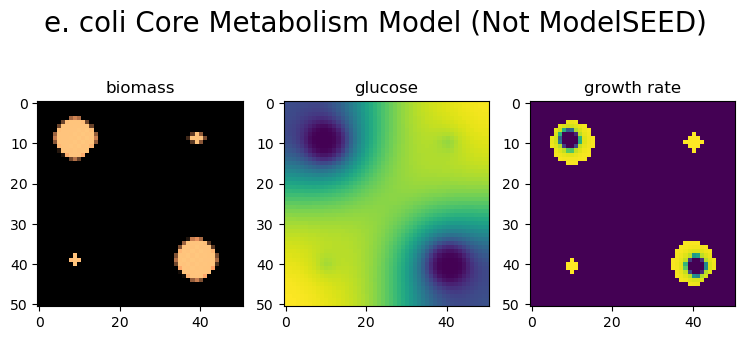

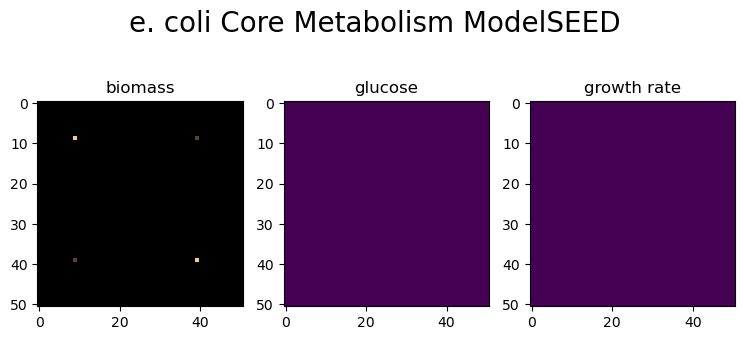

In [334]:
# Plot
[fig,axs]=plt.subplots(1,3,figsize=[9,4])

# Biomass
my_cmap = cmap.get_cmap("copper")
my_cmap.set_bad((0,0,0))
im = sim.get_biomass_image('e_coli_core', p.all_params["maxCycles"])
axs[0].imshow(im, norm = clrs.LogNorm(), cmap = my_cmap)
axs[0].set_title('biomass')

# glucose
axs[1].imshow(sim.get_metabolite_image("glc__D_e", p.all_params['maxCycles']))
axs[1].set_title('glucose')

# growth rate
im = sim.get_flux_image("e_coli_core", "BIOMASS_Ecoli_core_w_GAM", p.all_params["maxCycles"])
axs[2].imshow(im);
axs[2].set_title('growth rate')
fig.suptitle('e. coli Core Metabolism Model (Not ModelSEED)', fontsize=20)

[fig,axs]=plt.subplots(1,3,figsize=[9,4])

# Biomass
my_cmap = cmap.get_cmap("copper")
my_cmap.set_bad((0,0,0))
im = sim_ms.get_biomass_image('e_coli_core_ModelSEED', p.all_params["maxCycles"])
axs[0].imshow(im, norm = clrs.LogNorm(), cmap = my_cmap)
axs[0].set_title('biomass')

# glucose
axs[1].imshow(sim_ms.get_metabolite_image("cpd00027_e", p.all_params['maxCycles']))
axs[1].set_title('glucose')

# growth rate
im = sim_ms.get_flux_image("e_coli_core_ModelSEED", "bio1_biomass", p.all_params["maxCycles"])
axs[2].imshow(im);
axs[2].set_title('growth rate')
fig.suptitle('e. coli Core Metabolism ModelSEED', fontsize=20)
